In [9]:
import cv2
from pydicom import dcmread
import pandas as pd
from itertools import zip_longest
import numpy as np
from pt_ct import convert_ct_array
import matplotlib.pyplot as plt
from pydicom import dcmread, uid

In [44]:
with dcmread("/Volumes/WICHTIG/nods_str/rinker_strctrset.dcm", force=True) as fin:
    print(fin)
    fin.file_meta.TransferSyntaxUID = uid.ImplicitVRLittleEndian
    plt.imshow(fin.pixel_array)
    plt.show()

print("\n\n\n\n\n")

with dcmread("/Volumes/WICHTIG/patients/k/5/0004530179_PTVLK_Dose.dcm", force=True) as fin:
    print(fin)
    # fin.file_meta.TransferSyntaxUID = uid.ImplicitVRLittleEndian
    # plt.imshow(fin.pixel_array)
    # plt.show()


(0008, 0012) Instance Creation Date              DA: '20210909'
(0008, 0013) Instance Creation Time              TM: '150608.000000'
(0008, 0014) Instance Creator UID                UI: 2.16.840.1.114337
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10008.5.1.4.1.1.481.3.1631192762
(0008, 0020) Study Date                          DA: '20190807'
(0008, 0030) Study Time                          TM: '110703.393'
(0008, 0050) Accession Number                    SH: '1'
(0008, 0060) Modality                            CS: 'RTSTRUCT'
(0008, 0070) Manufacturer                        LO: 'Computerized Medical Systems'
(0008, 0090) Referring Physician's Name          PN: 'Unknown'
(0008, 1040) Institutional Department Name       LO: '0~Clinic'
(0008, 1090) Manufacturer's Model Name           LO: 'Monaco'
(0010, 0010) Patient's Name                      PN: 'Rinker^Günter^^^'
(0010, 0020) Patient ID     

AttributeError: Unable to convert the pixel data: one of Pixel Data, Float Pixel Data or Double Float Pixel Data must be present in the dataset

In [17]:
from matplotlib.pyplot import figimage
from numpy.lib.type_check import imag
from pydicom import dcmread
import numpy as np
from itertools import zip_longest
import cv2
import random
import pandas as pd


def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()


def create_target_pred_dvh(struc_data: dict, target_dose: np.ndarray, prediction_dose: np.ndarray) -> dict:

    max_dose = target_dose.max()
    dvh_x = np.linspace(0, max_dose, 1000, endpoint=True)

    struc_data = create_dvh(struc_data, target_dose, dvh_x, "target")
    struc_data = create_dvh(struc_data, prediction_dose, dvh_x, "prediction")

    return struc_data


def create_dvh(struc_data: dict, dose_array: np.ndarray, dvh_x: list, attribute_name: str) -> dict:

    for struc in struc_data:
        relevant_part = dose_array[struc["binary_mask"]].copy()
        num_vox = relevant_part.size

        dvh_data = []
        for threshold in dvh_x:
            dvh_data.append((relevant_part[relevant_part >= threshold].astype(bool).size)/num_vox)

        struc[attribute_name + "_dvh"] = dvh_data
        struc["dvh_x"] = dvh_x
        struc[attribute_name + "_D98"] = dvh_x[find_nearest(dvh_data, 0.02)]
        struc[attribute_name + "_Dmean"] = relevant_part.mean()
        struc[attribute_name + "_D2"] = dvh_x[find_nearest(dvh_data, 0.98)]

    return struc_data


def create_binary(structure_data: dict, ct_array: np.ndarray) -> dict:

    for struc in structure_data:
        binary = np.zeros_like(ct_array)
        for slice_ in struc["contour_data"]:
            poly = slice_[:, :2]
            img = binary[:, :, slice_[0, 2]].copy()
            binary[:, :, slice_[0, 2]] = cv2.fillPoly(img=img, pts=np.int32([poly]), color=1)
        struc["binary_mask"] = binary.astype(bool)

    return structure_data


def read_structures(strucure_file_path: str, image_origin: list, px_sp: list) -> dict:

    image_origin = np.array(image_origin)
    px_sp = np.array(px_sp)

    structures = []
    structures_data = []
    with dcmread(strucure_file_path, force=True) as dcm_in:
        for struc in dcm_in.StructureSetROISequence:
            structures.append({
                "struc_name": struc.ROIName,
                "struc_number": struc.ROINumber
            })

        for struc in dcm_in.ROIContourSequence:
            contour_data = []
            for data in struc.ContourSequence:
                contour_data.append(((np.array(data.ContourData).reshape((-1, 3))-image_origin)/px_sp).astype(int))
            structures_data.append({
                "struc_number": struc.ReferencedROINumber,
                "contour_data": contour_data
            })

    struc_data = [{**u, **v} for u, v in zip_longest(structures, structures_data, fillvalue={})]
    return struc_data


def analyse_structures(structure_file: str, origin: list, px_sp: list, ct_array: np.ndarray, target_dose: np.ndarray, prediction_dose: np.ndarray) -> dict:

    structures = read_structures(structure_file, origin, px_sp)
    structures = create_binary(structures, ct_array)
    structures = create_target_pred_dvh(structures, target_dose, prediction_dose)

    return structures


def plot_dvh(structures: dict) -> None:

    color = []
    n = len(structures)
    for _ in range(n):
        color.append('#%06X' % random.randint(0, 0xFFFFFF))

    legend = []

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    for num, struc in enumerate(structures):
        if not "z" in struc["struc_name"].lower():
            ax.plot(struc["dvh_x"], struc["target_dvh"], color=color[num])
            ax.plot(struc["dvh_x"], struc["prediction_dvh"], "--", color=color[num])
            legend.append(struc["struc_name"])
            legend.append(struc["struc_name"] + " pred")

    ax.legend(legend, bbox_to_anchor=(1.05, 0.5), loc='center left')
    fig.subplots_adjust(right=0.8)
    plt.show()


def main():

    from pt_ct import convert_ct_array

    px_sp = [1.17, 1.17, 3]
    origin = [-300, - 267.8, - 390.9]
    structure_file = "/Users/simongutwein/Studium/Masterarbeit/anonymized/test/pt0/pt0/pt0_strctr.dcm"
    ct_array = convert_ct_array("/Users/simongutwein/Studium/Masterarbeit/anonymized/test/pt0/cts", target_size=(512, 512, 125), tensor=True, ED=False)
    import torch
    import scipy.ndimage

    target_dose = torch.load("/Users/simongutwein/Studium/Masterarbeit/plan_predictions/p0_target.pt")
    target_dose = scipy.ndimage.zoom(target_dose, (1, 1, 125/target_dose.shape[2]))
    prediction_dose = torch.load("/Users/simongutwein/Studium/Masterarbeit/plan_predictions/p0_prediction.pt")
    prediction_dose = scipy.ndimage.zoom(prediction_dose, (1, 1, 125/prediction_dose.shape[2]))

    structures = analyse_structures(structure_file, origin, px_sp, ct_array, target_dose, prediction_dose)
    plot_dvh(structures)
    
    return structures


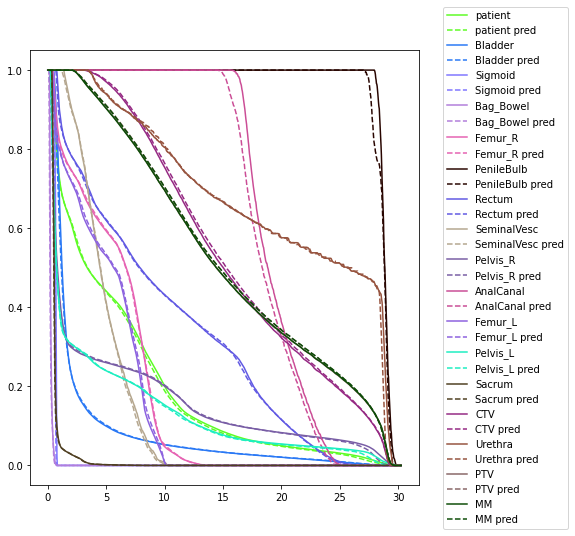

In [18]:
structures = main()

In [19]:

struc_df = pd.DataFrame(structures)


In [20]:
sub = struc_df[["struc_name", "target_D98", "target_D2", "target_Dmean", "prediction_D98", "prediction_D2", "prediction_Dmean"]]
sub.to_excel("/Users/simongutwein/Studium/Masterarbeit/test_data/data.xlsx")


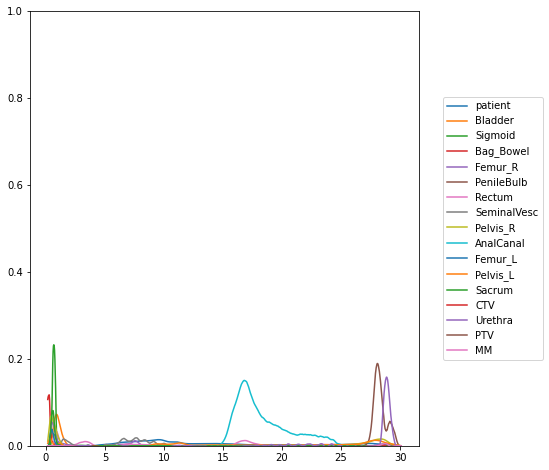

In [41]:
window_size = 10
legend = []

fig, ax = plt.subplots(1, 1, figsize=(8, 8))


for num, struc in enumerate(structures):

    if not "z" in struc["struc_name"].lower():

        target = np.array(struc["target_dvh"])
        prediction = np.array(struc["prediction_dvh"])

        running_mean = []
        for _ in range(np.floor(window_size/2).astype(int)):
            running_mean.append(np.nan)

        for idx in range(0, len(target)-window_size):
            running_mean.append((target[idx:idx+window_size]-prediction[idx:idx+window_size]).mean())

        for _ in range(np.ceil(window_size/2).astype(int)):
            running_mean.append(np.nan)

        ax.plot(struc["dvh_x"], running_mean)
        legend.append(struc["struc_name"])

ax.set_ylim([0, 1])
ax.legend(legend, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.subplots_adjust(right=0.8)
plt.show()



In [1]:
import torch
data = torch.load("/Users/simongutwein/Studium/Masterarbeit/test_data/p0_1/training_data.pt")


In [3]:
for i in data:
    print(i.min(), i.max())

tensor(0.) tensor(52.2633)
tensor(0.) tensor(1.2743)
tensor(0.) tensor(120.6366)
tensor(0.) tensor(227.6267)
tensor(0.) tensor(1.1408)
